clean version available at:  
- https://github.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/tree/main/Seminar3

Installing packages:
```
# polara
pip install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara
```

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, diags
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns # for better visual aesthetics
sns.set_theme(style='white', context='paper')
%config InlineBackend.figure_format = "svg"

from polara import get_movielens_data

from dataprep import leave_last_out, transform_indices, verify_time_split, reindex_data
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items, calculate_rmse

# Preparing data

In this excercise, we will again work with the Movielens-1M data.  
We will also follow the same "most-recent-item in holdout" strategy for simplicity.  
So the preparation code is the same is in the previous lecture.

In [2]:
data = get_movielens_data(include_time=True)

In [3]:
training_, holdout_ = leave_last_out(data, 'userid', 'timestamp')
verify_time_split(training_, holdout_)

In [4]:
training, data_index = transform_indices(training_, 'userid', 'movieid')
holdout = reindex_data(holdout_, data_index, filter_invalid=True)
holdout = holdout.sort_values('userid')

In [5]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    test_users = holdout[data_index['users'].name].values
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'n_users': 6040,
 'n_items': 3704,
 'test_users': array([   0,    1,    2, ..., 6037, 6038, 6039], dtype=int64)}

Let's also explicitly store our testset.

In [6]:
userid = data_description['users']
seen_idx_mask = training[userid].isin(data_description['test_users'])
testset = training[seen_idx_mask]

# Item-based KNN

Let's focus on item-based KNN.  We define a few convenience functions first.

In [7]:
def generate_interactions_matrix(data, data_description, rebase_users=False):
    '''
    Convert pandas dataframe with interactions into a sparse matrix.
    Allows reindexing user ids, which help ensure data consistency
    at the scoring stage (assumes user ids are sorted in scoring array).
    '''
    n_users = data_description['n_users']
    n_items = data_description['n_items']
    # get indices of observed data
    user_idx = data[data_description['users']].values # type your code here
    if rebase_users:
        user_idx, user_index = pd.factorize(user_idx, sort=True)
        n_users = len(user_index)
    item_idx = data[data_description['items']].values # type your code here
    feedback = data[data_description['feedback']].values # type your code here
    # construct rating matrix
    return csr_matrix((feedback, (user_idx, item_idx)), shape=(n_users, n_items))

def cosine_similarity_zd(matrix):
    '''Build cosine similarity matrix with zero diagonal.'''
    similarity = cosine_similarity(matrix, dense_output=False) # type your code here
    similarity.setdiag(0)
    similarity.eliminate_zeros()
    return similarity

And the main implementation starts here.  
If $A$ is a matrix of ratings and  $S$ is an item-similarity matrix ($s_{ij}\in[0, 1]$), then KNN-scores matrix $R$ is computed as:  

- for elementwise weighting:
$$
R=A S^{\top} \oslash\left(B S^{\top}\right),\quad
b_{u i}=\left\{\begin{array}{lr}
1, & \text { if } a_{u i} \text { is known } \\
0 & \text { otherwise }
\end{array}\right.
$$

- for row-wise weighting:
$$
R=AS^\top D_S^{-1},\quad
D_S=\operatorname{diag}(S\mathbf{e})
$$

- for unweighted case:
$$
R=AS^\top
$$

In [8]:
def build_iknn_model(config, data, data_description):
    # compute similarity matrix
    user_item_mtx = generate_interactions_matrix(data, data_description, rebase_users=False) # type your code here
    item_similarity = cosine_similarity_zd(user_item_mtx.T) # type your code here
    return item_similarity, config['weighting'] # complete your code with necessary output


def iknn_model_scoring(params, testset, testset_description):
    item_similarity, weighting = params
    user_item_mtx = generate_interactions_matrix(
        testset, testset_description, rebase_users=True
    ) # your code to generate n_test_users x n_items matrix
    scores = user_item_mtx.dot(item_similarity.T)
    if weighting is None:
        return scores.A

    if weighting == 'elementwise':
        weights = user_item_mtx.astype('bool').dot(np.abs(item_similarity.T))
        return np.divide(
            scores.A,
            weights.A,
            where=weights.A!=0
        )

    if weighting == 'rowwise':
        weights = np.abs(item_similarity).sum(axis=1).A.squeeze()
        return np.divide(
            scores.A,
            weights,
            where=weights!=0
        )
    raise ValueError('Unrecognized weighting scheme')


In [9]:
iknn_params_ew = build_iknn_model({'weighting': 'elementwise'}, training, data_description)
iknn_params_uw = build_iknn_model({'weighting': None}, training, data_description)
iknn_params_rw = build_iknn_model({'weighting': 'rowwise'}, training, data_description)

In [29]:
iknn_params_uw

(<3704x3704 sparse matrix of type '<class 'numpy.float64'>'
 	with 11295930 stored elements in Compressed Sparse Row format>,
 None)

In [10]:
iknn_scores_ew = iknn_model_scoring(iknn_params_ew, testset, data_description)
iknn_scores_uw = iknn_model_scoring(iknn_params_uw, testset, data_description)
iknn_scores_rw = iknn_model_scoring(iknn_params_rw, testset, data_description)

In [32]:
iknn_scores_uw.shape

(6038, 3704)

In [16]:
simmat = iknn_params[0]
simmat.nnz / np.prod(simmat.shape)

0.823341557081481

 ## Evaluation

### rating prediction quality

In [11]:
modes = ['unweighted', 'elementwise', 'rowwise']

In [12]:
iknn_scores = dict(zip(modes, [iknn_scores_uw, iknn_scores_ew, iknn_scores_rw]))
iknn_rmse = {}
for mode, scores in iknn_scores.items():
    iknn_rmse[mode] = rmse = calculate_rmse(scores, holdout, data_description)
    print(f'Weighting mode: {mode}\n{rmse=:.3f}\n')

Weighting mode: unweighted
rmse=27466.062

Weighting mode: elementwise
rmse=1.167

Weighting mode: rowwise
rmse=12.462



In [13]:
calculate_rmse(iknn_scores_ew, holdout, data_description)

1.16665668139785

In [14]:
calculate_rmse(iknn_scores_uw, holdout, data_description)

27466.061779281157

### top-n recommendations quality

In [15]:
downvote_seen_items(iknn_scores_ew, testset, data_description)
downvote_seen_items(iknn_scores_uw, testset, data_description)
downvote_seen_items(iknn_scores_rw, testset, data_description)

In [16]:
iknn_recs_ew = topn_recommendations(iknn_scores_ew, topn=10)
iknn_recs_uw = topn_recommendations(iknn_scores_uw, topn=10)
iknn_recs_rw = topn_recommendations(iknn_scores_rw, topn=10)

In [17]:
model_evaluate(iknn_recs_ew, holdout, data_description)

(0.0, 0.0, 0.0769438444924406)

In [18]:
model_evaluate(iknn_recs_uw, holdout, data_description)

(0.0669095727061941, 0.02581494450490807, 0.12823974082073433)

### models comparison

In [ ]:
# write code to print metrics of all KNN models with different weightings

In [19]:
iknn_recs = dict(zip(modes, [iknn_recs_uw, iknn_recs_ew, iknn_recs_rw]))
iknn_metrics = {}
for mode, recs in iknn_recs.items():
    iknn_metrics[mode] = metrics = model_evaluate(recs, holdout, data_description)
    print(
        f'Weighting mode: {mode}\n'\
        'HR={:.3}, MRR={:.3}, COV={:.3}\n'.format(*metrics)
    )

Weighting mode: unweighted
HR=0.0669, MRR=0.0258, COV=0.128

Weighting mode: elementwise
HR=0.0, MRR=0.0, COV=0.0769

Weighting mode: rowwise
HR=0.000497, MRR=9.43e-05, COV=0.0643



<font color=green>

- In your opinion, how the evaluation scores will change if we sample holdout items randomly?

</font>

## Analysis

In [20]:
iknn_recs = {
    'elemntwise': iknn_recs_ew,
    'unweighted': iknn_recs_uw
}

Let's analyse aggregated statistics for movie ratings.  It may give us hints on performance of KNN  models.

In [21]:
mode = 'unweighted' # name the weighting mode
recommended_items = pd.Series(iknn_recs[mode].ravel()).value_counts()

In [22]:
item_ratings = (
    training
    .groupby(data_description['items'])
    [data_description['feedback']]
    .agg(['size', 'mean', 'std'])
)

In [23]:
item_ratings.loc[recommended_items.head(5).index] # top-5 most frequent recommendations

size      mean       std
1106  2984  4.293566  0.844385
1178  2573  3.989118  0.864834
1108  2507  4.477064  0.726159
253   2979  4.453508  0.801759
1173  2267  3.953242  0.930754

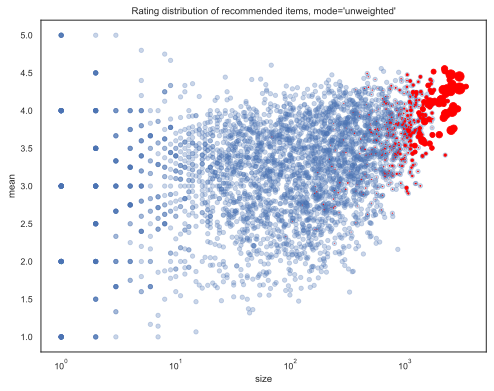

In [24]:
ax = item_ratings.plot.scatter(
    'size', 'mean', logx=True, alpha=0.3, figsize=(8, 6),
    title=f'Rating distribution of recommended items, {mode=}'
)
item_ratings.loc[recommended_items.index].plot.scatter(
    'size', 'mean', ax=ax, s=recommended_items*0.05, c='red'
);

In [26]:
ax = item_ratings.plot.scatter(
    'mean', 'std', s=0.05*item_ratings['size'],
    title=f'Rating deviation of recommended items, {mode=}'
);
item_ratings.loc[recommended_items.index].plot.scatter(
    'mean', 'std', ax=ax, c='red', s=recommended_items*0.05
);

# Neighborhood sampling

In [27]:
def truncate_similarity(similarity, k):
    '''
    For every row in similarity matrix, pick at most k entities
    with the highest similarity scores. Disregard everything else.
    '''
    similarity = similarity.tocsr()
    inds = similarity.indices
    ptrs = similarity.indptr
    data = similarity.data
    new_ptrs = [0]
    new_inds = []
    new_data = []
    for i in range(len(ptrs)-1):
        start, stop = ptrs[i], ptrs[i+1]
        if start < stop:
            data_ = data[start:stop]
            topk = min(len(data_), k)
            idx = np.argpartition(data_, -topk)[-topk:]
            new_data.append(data_[idx])
            new_inds.append(inds[idx+start])
            new_ptrs.append(new_ptrs[-1]+len(idx))
        else:
            new_ptrs.append(new_ptrs[-1])
    new_data = np.concatenate(new_data)
    new_inds = np.concatenate(new_inds)
    truncated = csr_matrix(
        (new_data, new_inds, new_ptrs),
        shape=similarity.shape
    )
    return truncated

## iKNN with neighborhood sampling

In [28]:
def build_sampled_iknn_model(config, data, data_description):
    # compute similarity matrix
    user_item_mtx = generate_interactions_matrix(data, data_description)
    item_similarity = truncate_similarity(
        cosine_similarity_zd(user_item_mtx.T),
        config['n_neighbors']
    )
    return item_similarity, config['weighting']

In [29]:
n_neighbors = 100

iknn_params_uw = build_sampled_iknn_model(
    {'weighting': None, 'n_neighbors': n_neighbors}, training, data_description
)
iknn_params_ew = build_sampled_iknn_model(
    {'weighting': 'elementwise', 'n_neighbors': n_neighbors}, training, data_description
)
iknn_params_rw = build_sampled_iknn_model(
    {'weighting': 'rowwise', 'n_neighbors': n_neighbors}, training, data_description
)

In [30]:
iknn_scores_ew = iknn_model_scoring(iknn_params_ew, testset, data_description)
iknn_scores_uw = iknn_model_scoring(iknn_params_uw, testset, data_description)
iknn_scores_rw = iknn_model_scoring(iknn_params_rw, testset, data_description)

### rating prediction quality

In [31]:
iknn_scores = dict(zip(modes, [iknn_scores_uw, iknn_scores_ew, iknn_scores_rw]))
iknn_rmse = {}
for mode, scores in iknn_scores.items():
    iknn_rmse[mode] = rmse = calculate_rmse(scores, holdout, data_description)
    print(f'Weighting mode: {mode}\n{rmse=:.3f}\n')

Weighting mode: unweighted
rmse=1440.168

Weighting mode: elementwise
rmse=1.204

Weighting mode: rowwise
rmse=9.147



### top-n recommendations quality

In [32]:
iknn_recs = {}

for mode, iknn_scores in zip(modes, [iknn_scores_uw, iknn_scores_ew, iknn_scores_rw]):
    downvote_seen_items(iknn_scores, testset, data_description)
    iknn_recs[mode] = topn_recommendations(iknn_scores, topn=10)

In [33]:
iknn_metrics = {}
for mode, recs in iknn_recs.items():
    iknn_metrics[mode] = metrics = model_evaluate(recs, holdout, data_description)
    print(
        f'Weighting mode: {mode}\n'\
        'HR={:.3}, MRR={:.3}, COV={:.3}\n'.format(*metrics)
    )

Weighting mode: unweighted
HR=0.079, MRR=0.0286, COV=0.349

Weighting mode: elementwise
HR=0.000828, MRR=0.000224, COV=0.994

Weighting mode: rowwise
HR=0.0644, MRR=0.0216, COV=0.567



### Analysis

In [ ]:
mode = ... # name the weighting mode
recommended_items = pd.Series(iknn_recs.ravel()).value_counts()

In [ ]:
ax = item_ratings.plot.scatter(
    'size', 'mean', logx=True, alpha=0.3, figsize=(8, 6),
    title=f'Rating distribution of recommended items, {mode=}'
)
item_ratings.loc[recommended_items.index].plot.scatter(
    'size', 'mean', ax=ax, s=recommended_items*0.05, c='red'
);

In [ ]:
ax = item_ratings.plot.scatter(
    'mean', 'std', s=0.05*item_ratings['size'],
    alpha=0.3, figsize=(8, 6),
    title=f'Rating deviation of recommended items, {mode=}'
);
item_ratings.loc[recommended_items.index].plot.scatter(
    'mean', 'std', ax=ax, c='red', s=recommended_items*0.05
);

<font color=green>  

* Explain why neighborhood sampling changed the picture that way?

</font>

# Asymmetric iKNN with column-wise weighting

- for column-wise weighting:
$$
R=A D_S^{-1}S^\top
$$

In [34]:
def asy_iknn_model_scoring(params, testset, testset_description):
    item_similarity, weighting = params
    user_item_mtx = generate_interactions_matrix(
        testset, testset_description, rebase_users=True
    )
    item_similarity, weighting = params
    user_item_mtx = generate_interactions_matrix(
        testset, testset_description, rebase_users=True
    ) # your code to generate n_test_users x n_items matrix

    if weighting == 'columnwise':
        weights = np.abs(item_similarity).sum(axis=1).A.squeeze()
        r_weights = np.divide(1., weights, where=weights!=0)
        n_user_item_matrix = user_item_mtx.dot(diags(r_weights))
        scores = n_user_item_matrix.dot(item_similarity.T)
        return scores.A
    raise ValueError('Unrecognized weighting scheme')

In [35]:
iknn_params_cw = build_sampled_iknn_model(
    {'weighting': 'columnwise', 'n_neighbors': n_neighbors}, training, data_description
)
iknn_scores_cw = asy_iknn_model_scoring(iknn_params_cw, testset, data_description)

In [36]:
downvote_seen_items(iknn_scores_cw, testset, data_description)
iknn_recs_cw = topn_recommendations(iknn_scores_cw)

In [37]:
model_evaluate(iknn_recs_cw, holdout, data_description)

(0.07784034448492878, 0.02812754670157784, 0.44033477321814257)

Weighting mode: rowwise  
HR=0.0644, MRR=0.0216, COV=0.567

# User-based KNN

Recall, there's no reason for implementing row-wise weighting scheme in user-based KNN.  
So the options are

- for element-wise weighting:
$$
R=K A \oslash\left(K B\right)
$$


- for unweighted case:
$$
R=KA
$$

where $K$ is a user-similarity matrix. 

Note that the implementation of similarity calculation now has to take into account test users which may be unknown at the build stage.

In [ ]:
def build_uknn_model(config, data, data_description):
    user_item_mtx = generate_interactions_matrix(data, data_description)
    # compute similarity matrix and normalization coefficients
    user_similarity = ...
    weighted = config['weighted']
    return user_item_mtx, user_similarity, weighted

def uknn_model_scoring(params, testset, testset_description):
    user_item_mtx, user_similarity, weighted = params
    test_users = testset_description['test_users']

    if not weighted:
        return ...

    normalizer = ...
    return ...

In [ ]:
uknn_params_uw = build_uknn_model(
    {'weighted': False}, training, data_description
)
uknn_params_ew = build_uknn_model(
    {'weighted': True}, training, data_description
)

In [ ]:
uknn_scores_uw = uknn_model_scoring(uknn_params_uw, None, data_description)
uknn_scores_ew = uknn_model_scoring(uknn_params_ew, None, data_description)

 ## Evaluation

### top-n recommendations quality

In [ ]:
downvote_seen_items(uknn_scores_uw, testset, data_description)
downvote_seen_items(uknn_scores_ew, testset, data_description)

In [ ]:
uknn_recs_uw = topn_recommendations(uknn_scores_uw)
uknn_recs_ew = topn_recommendations(uknn_scores_ew)

In [ ]:
modes = ['unweighted', 'elementwise']
uknn_recs = dict(zip(modes, [uknn_recs_uw, uknn_recs_ew]))


uknn_metrics = {}
for mode, recs in uknn_recs.items():
    uknn_metrics[mode] = metrics = model_evaluate(recs, holdout, data_description)
    print(
        f'Weighting mode: {mode}\n'\
        'HR={:.3}, MRR={:.3}, COV={:.3}\n'.format(*metrics)
    )

### Rating prediction

In [ ]:
uknn_scores = dict(zip(modes, [uknn_scores_uw, uknn_scores_ew]))
uknn_rmse = {}
for mode, scores in uknn_scores.items():
    uknn_rmse[mode] = rmse = calculate_rmse(scores, holdout, data_description)
    print(f'Weighting mode: {mode}\n{rmse=:.3f}\n')

<font color=green>

- Try to explain, why user-based KNN with element-wise weighting provides slightly better RMSE scores than its item-based counterpart?

</font>

# Bulk run helpers

```python
modes = ['unweighted', 'elementwise', 'rowwise']
iknn_recs = dict(zip(modes, [iknn_recs_uw, iknn_recs_ew, iknn_recs_rw]))
iknn_metrics = {}
for mode, recs in iknn_recs.items():
    iknn_metrics[mode] = metrics = model_evaluate(recs, holdout, data_description)
    print(
        f'Weighting mode: {mode}\n'\
        'HR={:.3}, MRR={:.3}, COV={:.3}\n'.format(*metrics)
    )
```

```python
iknn_scores = dict(zip(modes, [iknn_scores_uw, iknn_scores_ew, iknn_scores_rw]))
iknn_rmse = {}
for mode, scores in iknn_scores.items():
    iknn_rmse[mode] = rmse = calculate_rmse(scores, holdout, data_description)
    print(f'Weighting mode: {mode}\n{rmse=:.3f}\n')
```